# Learning from the data

In the last notebook (5.3), we created the feature vector that we want to use to learn the conditions that lead to regulations. In this notebook, we will load the dataset, select the most promising features, normalize and scale them, and finally run a classifier on them.

As the goal of the thesis is to discuss the learnability of the problem and not to acheive production-grade performance, we will use the well-known basic algorithms provided by the Python package [scikit-learn](www.scikit-learn.org). The following picture (http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) provides a "path" through the variety of algorithms available in the library. It should be noted that Neural Networks are not an integral part of the scikit-learn library.

<img src="images/ml_map.png",width=85%,height=85%>

# 0. Imports

In [1]:
import os.path, pandas as pd 
import matplotlib as mp, matplotlib.pyplot as plt
import numpy as np, json, random, ast
from IPython.display import clear_output
from pandas.io.json import json_normalize, read_json
from datetime import datetime
from IPython.display import HTML

import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

#Set some parameters for nicer visualizations
pd.set_option('display.expand_frame_repr', False) #do not wrap the printout of Pandas DataFrames
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 50)
mp.rcParams['figure.figsize'] = (15, 12)
mp.pyplot.style.use = 'fivethirtyeight'
%matplotlib inline

In [9]:
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = skl.metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = skl.metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area ={0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show();

In [3]:
dfmain = pd.read_csv('data/dffinal.csv', index_col=0)
dfmain['geojson'] = dfmain['geojson'].map(ast.literal_eval) #convert string to dict
dfmain['sta'] = pd.to_datetime(dfmain['sta'])
dfmain['end'] = pd.to_datetime(dfmain['end'])
dfmain['duration'] = pd.to_timedelta(dfmain['duration'])   
dfmain.sample()

,icao,s,iata,wkt,geojson,sta,end,duration,rwys,humidity,dewPoint,temperature,pressure,visibility,windBearing,windSpeed,windGust,precipIntensity,precipProbability,storm,dat.cape,dat.tempk,dat.press,dat.humi,dat.precip,crosswind,cap,demand,ratio,regulated
1212,LEBL,Place_Barcelona_ElPrat_Airport,BCN,POINT (2.0783333778381348 41.29694366455078),"{'type': 'Point', 'coordinates': [2.0783333778...",2016-04-08 05:00:00,2016-04-08 05:59:59,00:59:59,250,0.71,4.75,9.78,1010.9,10.19,335.0,4.09,0.0,0.0,0.0,0,0.0,9.3,98464.28,83.0,7.30e-05,4.07,48,41.0,0.85,0


# 1. Some preconsiderations

In the last notebok (5.3) we made some basic analysis on the available wx and other parameters. Deriving from these insights, we could conclude that we are 1) dealing with an imbalanced problem, and 2) some wx parameters did not play a role for our subset of data from April 2016  for seasonal reasons (e.g. no storm data available). 

## a) Dealing with an imbalanced problem: Defining Evaluation Metrics

In many applications (e.g. fraud detection), the minority class contains the more important or costly events. The same applies to our problem, as has been commented by CRIDA in our interview. Therefore, the estimator should have the tendency to capture as many of the critical entries as possible, even at the cost of misclassifying uncritical entries. The simple accuracy metric is not sufficient for these types of problems, because if, like in our case, the problem is imbalanced so that 94% of the entries belong to one class, a completely naive classifier that would just classify all items as belonging to the majority class, would acheive an accuracy of 94%, but would classify 100% of the minority entries wrong.   The following  definitions adapted from [Fawcett, T: An introduction to ROC analysis](http://dx.doi.org/10.1016/j.patrec.200) help to formalize the problem and select the correct scoring methods. The confusion matrix allows us to define different metrics:

<img src="images/confusion_matrix_1.png">

We define a regulated event as belonging to the "positive class", the label encoded as 1 in the dataset, and a non-regulated event as belonging to the "negative class" with the label 0. Considering the reply from CRIDA, it is critical to catch as much of the regulated events as possible, even at the cost of having some false positives in the result set. Lets define this more exactly. Let $m$ be the total of observations. Let

$$
 \begin{align}
accuracy &= \frac{TP + TN}{m} \\
tp rate \ (recall) &= \frac{TP}{TP + FP} \\
fp rate &= \frac{FP}{FP + TN} 
\end{align}
 $$

We can now state that for our purposes, the $tp \ rate$ should be optimized, even at the expense of collecting some false positives. The classifiers will internally compute a class probability between 0 and 1 for each predicted outcome. For example, a certain dataset might be classified as "0.85 probability of being not regulated". By shifting the classification threshold away from 0.5, we can adjust the number of events that are classified as "positive", with the tradeoff of increasing ambiguity. If we plot $tp \ rate$ against $fp \ rate$ on a chart for each probability threshold, we get the so-called ROC-curve:

<img src="images/roccurve.png" width=30%,height=30%>

The goal of the ML process is to attain a high $tp \ rate$ and a low $fp \ rate$. Therefore, the more prononced the bend of the curve away from the luck line $f(x) = x$ is, the better the classifier. This "bending" can also be measured by the metric $AUC$, which stands for "area under the curve" and is literally the area under the ROC curve, the graph being normalized to having a total area of 1. An AUC of .5 would mean that there is no difference to guessing, and an AUC of 1 would represent the ideal classifier. The problem is _learnable_ if a definitive bend away from the luck line can be observed. We are dealing with an imbalanced dataset. To gain an initial understanding, we calculate a baseline first. This baseline represents the performance that would be acheived by a primitive classifier that classifies all entries as belonging to the majority class. The following code prints the confusion matrix that would correspond to such a classifier and operated on our dataset:


## c) Dealing with non-relevant features

Our dataset contains only April 2016. As the Iberian peninsula is subject to seasonal climate changes, we do not have all possible weather conditions in our sample dataset. For example, we do not have storm conditions or freezing precipitation in our dataset. An experiment on a larger data basis should consider these variables, for our purpos here, we will omit them.

## c) Other considerations (preprocessing, hyperparameter selection, cross validation)

The scikit-learn API makes it very easy to apply advanced learning methods to our model. We can perform a Grid Search on the hyperparameters so that the best hyperparameters are found for us. It is easy to implement cross-validation into the learning process. We plan to use these features provided by the API. 

Apart from the correct analysis, different algorithmic methods are available to deal with imbalanced problems. Some examples are oversampling and undersampling. We are going to use a vanilla and an oversampled dataset to compare the results of the oversampling method. Oversampling works as follows:

  $$ \ demonstrate \ oversampling $$

# 2. Data Preprocessing and Baseline Calculation

Given the thoughts above, we select the useful features, and split the data into training and test sets (the pipelines later on will further split the training sets into cross-validation subsets). Additionally, we define what the baseline for our learning experiment will be. 

In [25]:
# 0. Create the feature matrix and label vector as numpy-Arrays.
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

The following cell calculates the baseline of a naive classifier that always selects the majority class.

[[936   0]
 [ 72   0]]


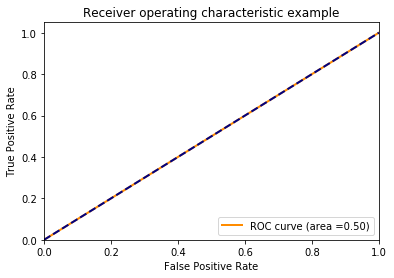

In [26]:
y_dumb = np.zeros((len(y_test), 1))
baseline = skl.metrics.confusion_matrix(y_test, y_dumb)
print(baseline)
plot_roc(y_test, y_dumb)

# 3. Training a Support Vector Classifier

### Preconsiderations

#### Data Normalization
Feature normalization has the purpose of leveling different features into a comparable numerical dimension. While _scaling_ only levels the numerical range of the features, _normalization_ refers to a transformation that generates an input matrix where the features have 0 mean and equal variance across the observations. We will be using `sklearn` for this purpose. In `sklearn`, two different classes implement scaling and normalization, respectively: `MinMaxScaler` and `StandardScaler`. TODO ...

As described in the `sklearn` documentation, scaling is more common to preprocess data for Neural Nets, while normalization is being used for Support Vector Machines and alike. It should be noted that the scaling/normalization process (data transformation) should be learned from the training set, and only _applied_ to the test set. But because we are using k-fold cross validation, this step has to be recomputed for each fold. Therefore, the sklearn documentation advises to embed the normalization process into a `pipeline` which is an sklearn class that chains estimators together.

#### Cross Validation

lorem ipsum

### Construction

In [33]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

# 1. Instantiate a normalizer. Beware to fit on train, and only tranform on test (Cross Valid will do this for us)
normer = preprocessing.Normalizer()


# 2. Instantiate a Linear Support Vector Classifier.
     # For Hyperparameter tuning, we will pay special attention to class weight due to the imbalanced dataset. 
svm1 = svm.SVC(probability=True, class_weight={1: 10})


# 3. Forge normalizer and classifier into a pipeline. Make sure the pipeline steps are memorizable during the grid search.
cached = mkdtemp()
memory = Memory(cachedir=cached, verbose=10)
pipe_1 = Pipeline(steps=[('normalization', normer), ('svm', svm1)], memory=memory)


# 4. Instantiate Cross Validation
cv = skl.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)


# 5. Instantiate the Grid Search for Hypereparameter Tuning
#    As the normalizer and estimators are hidden in the pipeline, we pass the grid parameters
#    with the '_' notation as described in scikit learn documentation: http://bit.ly/2AlhUaK
param_grid = [ {"svm__kernel": ["linear"], "svm__C": [1, 10, 100, 1000]}, 
               {"svm__kernel": ["rbf"], "svm__C": [1, 10, 100, 1000], "svm__gamma": [0.001, 0.0001]} ]
grd = GridSearchCV(pipe_1, param_grid, scoring='roc_auc', cv=cv)

# 6. Delete the temporary grid before exiting
rmtree(cached)



### Training

In [34]:
#fit the classifier to the training dataset
pipe_1.fit(X_train, y_train)

#transoform X_test according to the fitted normalizer, then predict
#X_test_norm = normer.transform(X_test)
#y_pred = pipe_1.predict(X_test_norm)

X_train_norm = normer.fit_transform(X_train)
X_test_norm = normer.fit(X_test)
y_pred = grd.fit(X_train_norm, y_train).predict(X_test)

# y_pred = grd.fit(X_train, y_train).predict(X_test)
# clf = GridSearchCV(SVC(), param_grid, scoring="f1", cv=10) 
# clf.fit(X_train, y_train) 
# y_pred = clf.predict(X_test)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Normalizer(copy=True, norm='l2'), None, array([[ 0.65    , ...,  0.545455],
       ..., 
       [ 0.9     , ...,  0.      ]]), 
array([0, ..., 0]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Normalizer(copy=True, norm='l2'), None, array([[ 0.000638, ...,  0.000536],
       ..., 
       [ 0.000885, ...,  0.      ]]), 
array([0, ..., 0]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Normalizer(copy=True, norm='l2'), None, array([[ 0.00085 , ...,  0.000878]

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /tmp/tmpemxwouuc/joblib/sklearn/pipeline/_fit_transform_one/283c6675b39f8631d0d4bd0a570a9158
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /tmp/tmpemxwouuc/joblib/sklearn/pipeline/_fit_transform_one/31f321d3d7d17723e0262815fb41f66e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /tmp/tmpemxwouuc/joblib/sklearn/pipeline/_fit_transform_one/bd4bc10fde1588a5cd9d68338daf884e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /tmp/tmpemxwouuc/joblib/sklearn/pipeline/_fit_transform_one/d44fbe637fa372c379704b8acee2fea6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from /tmp/tmpemxwou

### Evaluation

[[858  78]
 [ 43  29]]


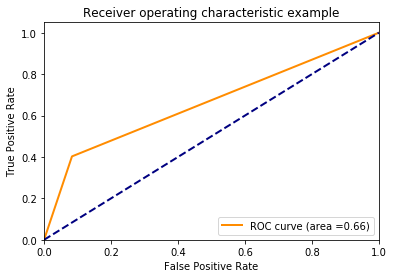

In [35]:
confmatrix = skl.metrics.confusion_matrix(y_test, y_pred)
print(confmatrix)
plot_roc(y_test, y_pred)

In [ ]:
y_pred_prob = grd.predict_proba(X_test)
y_pred_prob

# Code snippets

In [ ]:
plt.rcParams['font.size'] = 14
plt.hist(y_pred_prob, bins=18)
plt.xlim(0,1)
plt.title('Histogram of Regulation probabilities')
plt.xlabel('Predicted Prob')
plt.ylabel('Frequency')

In [18]:
import itertools
from ipywidgets import widgets

class_names=[0, 1]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def confadjust(x):   
    # Compute confusion matrix
    y_pred_prob = grd.predict_proba(X_test)
    y_pred_class = skl.preprocessing.binarize(y_pred_prob, threshold=x)[: , 1]    
    cnf_matrix = skl.metrics.confusion_matrix(y_test, y_pred_class)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion Matrix')
    plt.show()


widgets.interact(confadjust, x=widgets.FloatSlider(value=.5,min=0,max=1.0,step=0.01, description='Threshold'));



interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

# 5. Interactive Adjustments

We will let the user decide interactively, which threshhold probability to use.


In [ ]:
#fit a logistic regression model

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2,3), penalty: {'11','12'}}

cv = KFold(X_train.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train, y_train)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_



#Ausführlicher Testreport:
from sklearn.metrics import classification_report
print classification_report(y_test, clf.predict(X_test))



SMOTE oversampling technique:

 - paper lesen
 - ist eine datenorientierte resampling technik, um mit imbalance zu copen
 
 os = SMOTE(ratio=0.5, k=5, random_state=1)
 X_train_res, y_train_res = os.fit_sample(X_train, y_train)
 
 
.... danach hat man ein größeres Dataset und kann die ML Classifier ganz normal anwenden

 

In [ ]:
from sklearn.pipeline import FeatureUnion, Pipeline from sklearn.decomposition import PCA, KernelPCA 
from sklearn.feature_selection import SelectKBest
union = FeatureUnion([("pca", PCA()), ("kpca", KernelPCA(kernel="rbf"))])
Pipeline([("feat_union", union), 
          ("feat_sel", SelectKBest(k=10)), 
          ("log_reg", LogisticRegression(penalty="l2")) ]).fit(X_train, y_train).predict(X_test)

statt GridSearchCV könnte ich auch RandomizedSearchCV nehmen. Diese Algorithmen sind dann auch für die Cross-Validation (k-fold) und die score functions zuständig. The score function used by default is the estimator’s score method, but the library provides a variety of alternatives that the user can choose from, including accuracy, AUC and F1 score for classification, R2 score and mean squared error for regression.

In [ ]:
from sklearn.grid_search import GridSearchCV 
from sklearn.svm import SVC
param_grid = [ {"kernel": ["linear"], "C": [1, 10, 100, 1000]}, 
               {"kernel": ["rbf"], "C": [1, 10, 100, 1000], "gamma": [0.001, 0.0001]} ]
clf = GridSearchCV(SVC(), param_grid, scoring="f1", cv=10) 
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)